# MATSim Plans - Sequence to Sequence

## Part 1 - Pre-processing

Demo of parsing MATSim (experienced) plans for a sequence to sequence model.

MATSim plans from multiple iteration of the same run are processed into plan pairs. Where each pair is composed of an input plan and target plan. Where the target plan is from the same agent but from an iteration with higher utility score for that agent.

Note that this extracts plan activities and trips. Each sequence component includes duration, mode and distance.

In [6]:
from pathlib import Path
import pandas as pd

from pam.read.matsim import load_attributes_map_from_v12, stream_matsim_persons
from pam.utils import datetime_to_matsim_time
from pam.core import Population, Person
from pam.activity import Leg

In [7]:
dir = Path("data/matsim")

# input paths
output_plans_path = dir / "output_plans.xml"
iter_50 = dir / "output_experienced_plans_ITER50.xml"
assert iter_50.exists()
iter_100 = dir / "output_experienced_plans_ITER100.xml"
assert iter_100.exists()
iter_150 = dir / "output_experienced_plans_ITER150.xml"
assert iter_150.exists()

# output path
output_dir = Path("tmp")
output_dir.mkdir(exist_ok=True)
lhs_path = output_dir / "lhs.csv"
rhs_path = output_dir / "rhs.csv"
combined_path = output_dir / "combined.csv"
attributes_path = output_dir / "attributes.csv"

In [8]:
streamer50 = stream_matsim_persons(
    iter_50,
    simplify_pt_trips=True,
    # crop=True,
    keep_non_selected=False,
    leg_attributes=True,
    leg_route=True,
)
streamer100 = stream_matsim_persons(
    iter_100,
    simplify_pt_trips=True,
    # crop=True,
    keep_non_selected=False,
    leg_attributes=True,
    leg_route=True,
)
streamer150 = stream_matsim_persons(
    iter_150,
    simplify_pt_trips=True,
    # crop=True,
    keep_non_selected=False,
    leg_attributes=True,
    leg_route=True,
)
streamers = [streamer50, streamer100, streamer150]

In [9]:
def dt_to_min(dt) -> int:
    h, m, s = datetime_to_matsim_time(dt).split(":")
    return (int(h) * 60) + int(m)


def person_to_schedule(person: Person) -> tuple:
    score = person.plan.score
    if score is None:
        score = 0
    record = []
    for component in person.plan:
        if isinstance(component, Leg):
            distance = component.euclidean_distance
            mode = component.mode
        else:
            distance = 0
            mode = "NA"
        record.append(
            [
                component.act,
                dt_to_min(component.start_time),
                dt_to_min(component.end_time),
                mode,
                distance,
            ]
        )
    return (person.pid, (score, [record]))


def pam_to_schedules(population: Population) -> dict:
    return dict([person_to_schedule(person) for person in population])


def add_pid(record, pid):
    record = [[pid] + line for line in record]
    return record

In [10]:
best = pam_to_schedules(streamer50)

lhss = []
rhss = []
mapper = {}
i = 0

for s, streamer in enumerate(streamers):
    print("streaming: ", s)
    for person in streamer:
        pid, (score, (record,)) = person_to_schedule(person)
        existing_score, existing_records = best[pid]
        if score > existing_score:
            new_records = existing_records + [record]
            for existing in existing_records:
                if len(record) == len(
                    existing
                ):  # protection against cropped plans
                    lhss.extend(add_pid(existing, i))
                    rhss.extend(add_pid(record, i))
                    mapper[i] = pid
                    i += 1
            best[pid] = (score, new_records)

streaming:  0
streaming:  1
streaming:  2


In [11]:
lhs = pd.DataFrame(
    lhss, columns=["pid", "act", "start", "end", "mode", "distance"]
).set_index("pid")
rhs = pd.DataFrame(
    rhss, columns=["pid", "act", "start", "end", "mode", "distance"]
).set_index("pid")

In [12]:
attributes = load_attributes_map_from_v12(output_plans_path)
attributes = {k: attributes[v] for k, v in mapper.items()}
attributes = pd.DataFrame(attributes).T
attributes.index.name = "pid"
attributes = attributes.fillna("unknown")
attributes.head()

,subpopulation,age
pid,,
0,rich,yes
1,poor,no
2,poor,no
3,poor,no
4,poor,no


In [13]:
assert len(lhs.index.unique()) == len(rhs.index.unique()) == len(attributes)
len(attributes)

8

In [14]:
combined = pd.concat(
    [
        lhs,
        rhs.rename(
            columns={
                "act": "target_act",
                "start": "target_start",
                "end": "target_end",
                "mode": "target_mode",
                "distance": "target_distance",
            }
        ),
    ],
    axis=1,
)
combined["target_duration"] = combined["target_end"] - combined["target_start"]

lhs.to_csv(lhs_path)
rhs.to_csv(rhs_path)
attributes.to_csv(attributes_path)
combined.to_csv(combined_path)

## Part 2 - Evaluation

Demo of comparison of utility scores for input, target and predicted plans to evaluate quality of model outputs.

In [15]:
from pathlib import Path
import pandas as pd
import numpy as np

from pam.core import Person
from pam.activity import Activity, Leg, Plan
from pam.scoring import CharyparNagelPlanScorer
from pam.utils import minutes_to_datetime
from pam.plot import plot_persons

In [16]:
dir = Path("data/seq2seq")
test_path = dir / "test_input.csv"
target_path = dir / "test_target.csv"
pred_path = dir / "pred.csv"

test = pd.read_csv(test_path)
target = pd.read_csv(target_path)
pred = pd.read_csv(pred_path)

for df in [test, target, pred]:
    df["duration"] = df.end - df.start

# pred.distance = test.distance
# pred.start[pred.start > 1440] = 1440
# pred.end[pred.end > 1440] = 1440

In [17]:
test.head()

,pid,act,start,end,mode,distance,duration
0,0,home,0,420,NaN,0.0,420
1,0,travel,420,427,car,10.1,7
2,0,work,427,990,NaN,0.0,563
3,0,travel,990,997,car,10.1,7
4,0,home,997,1440,NaN,0.0,443


In [18]:
target.head()

,pid,act,start,end,mode,distance,duration
0,0,home,0,420,NaN,0.0,420
1,0,travel,420,427,car,10.1,7
2,0,work,427,990,NaN,0.0,563
3,0,travel,990,997,car,10.1,7
4,0,home,997,1440,NaN,0.0,443


In [19]:
pred.head()

,pid,act,start,end,mode,distance,duration
0,0,home,0,300,NaN,0.0,300
1,0,travel,300,400,car,10.1,100
2,0,work,400,990,NaN,0.0,590
3,0,travel,990,997,car,10.1,7
4,0,home,997,1440,NaN,0.0,443


In [20]:
# structural check
matches = 0
misses = 0


for (_, t), (_, p) in zip(test.groupby("pid"), pred.groupby("pid")):
    if list(t.act) == list(p.act):
        matches += 1
    else:
        misses += 1
print(
    f"matches: {matches}, misses: {misses}, ratio: {matches / (matches + misses)}"
)

matches: 8, misses: 0, ratio: 1.0


In [21]:
# mode shift check
mode_shifts = 0
correct = 0
shifts = {}
for (_, t), (_, tar), (_, p) in zip(
    test.groupby("pid"), target.groupby("pid"), pred.groupby("pid")
):
    for mt, mtar, mpred in zip(
        list(t["mode"]), list(tar["mode"]), list(p["mode"])
    ):
        if isinstance(mt, str) and (mt != mpred):
            mode_shifts += 1
            change = f"{mt} -> {mpred}"
            shifts[change] = shifts.get(change, 0) + 1
            if mpred == mtar:
                correct += 1

print(f"mode shifts: {mode_shifts}")
print(f"correct mode shifts: {correct}, ratio: {correct / mode_shifts}")
print(shifts)

mode shifts: 2
correct mode shifts: 0, ratio: 0.0
{'pt -> car': 2}


In [22]:
# duration check
longer = 0
correct_longer = 0
shorter = 0
correct_shorter = 0

for (_, t), (_, tar), (_, p) in zip(
    test.groupby("pid"), target.groupby("pid"), pred.groupby("pid")
):
    for dt, dtar, dpred in zip(
        list(t["duration"]), list(tar["duration"]), list(p["duration"])
    ):
        if dpred > dt:
            longer += 1
            if dtar > dt:
                correct_longer += 1
        elif dpred < dt:
            shorter += 1
            if dtar < dt:
                correct_shorter += 1

print(
    f"longer: {longer}, correct longer: {correct_longer}, ratio: {correct_longer / longer}"
)
print(
    f"shorter: {shorter}, correct shorter: {correct_shorter}, ratio: {correct_shorter / shorter}"
)

longer: 7, correct longer: 0, ratio: 0.0
shorter: 5, correct shorter: 0, ratio: 0.0


In [23]:
# scoring
config = {
    "mUM": 1,
    "utilityOfLineSwitch": -1,
    "performing": 10,
    "waiting": 0,
    "waitingPt": 0,
    "lateArrival": 0,
    "earlyDeparture": 0,
    "home": {"typicalDuration": "10:00:00", "minimalDuration": "01:00:00"},
    "work": {
        "openingTime": "07:00:00",
        "closingTime": "19:30:00",
        "minimalDuration": "06:00:00",
        "typicalDuration": "09:00:00",
    },
    "delivery": {
        "openingTime": "06:00:00",
        "closingTime": "20:00:00",
        "minimalDuration": "00:30:00",
        "typicalDuration": "01:00:00",
    },
    "depot": {
        "openingTime": "00:00:00",
        "closingTime": "23:59:59",
        "minimalDuration": "00:30:00",
        "typicalDuration": "04:00:00",
    },
    "education": {
        "openingTime": "08:30:00",
        "closingTime": "17:00:00",
        "minimalDuration": "06:00:00",
        "typicalDuration": "06:00:00",
    },
    "other": {"minimalDuration": "00:10:00", "typicalDuration": "00:30:00"},
    "shop": {
        "openingTime": "08:30:00",
        "closingTime": "19:30:00",
        "minimalDuration": "00:30:00",
        "typicalDuration": "00:30:00",
    },
    "visit": {"minimalDuration": "00:30:00", "typicalDuration": "02:00:00"},
    "medical": {
        "openingTime": "09:00:00",
        "closingTime": "18:00:00",
        "minimalDuration": "00:30:00",
        "typicalDuration": "01:00:00",
    },
    "business": {
        "openingTime": "07:30:00",
        "closingTime": "20:00:00",
        "minimalDuration": "00:30:00",
        "typicalDuration": "01:00:00",
    },
    "escort_home": {
        "minimalDuration": "00:05:00",
        "typicalDuration": "00:05:00",
    },
    "escort_work": {
        "openingTime": "07:00:00",
        "closingTime": "19:30:00",
        "minimalDuration": "00:05:00",
        "typicalDuration": "00:05:00",
    },
    "escort_business": {
        "openingTime": "07:00:00",
        "closingTime": "19:30:00",
        "minimalDuration": "00:05:00",
        "typicalDuration": "00:05:00",
    },
    "escort_education": {
        "openingTime": "08:30:00",
        "closingTime": "17:00:00",
        "minimalDuration": "00:05:00",
        "typicalDuration": "00:05:00",
    },
    "escort_other": {
        "minimalDuration": "00:05:00",
        "typicalDuration": "00:05:00",
    },
    "escort_shop": {
        "openingTime": "08:30:00",
        "closingTime": "17:30:00",
        "minimalDuration": "00:05:00",
        "typicalDuration": "00:05:00",
    },
    "car": {
        "constant": -4,
        "marginalUtilityOfDistance": 0,
        "marginalUtilityOfTravelling": -2,
        "monetaryDistanceRate": -0.00009,
    },
    "bike": {
        "constant": -0.5,
        "marginalUtilityOfDistance": -0.001,
        "marginalUtilityOfTravelling": 0,
        "monetaryDistanceRate": 0,
    },
    "walk": {"marginalUtilityOfDistance": -0.001},
    "bus": {"monetaryDistanceRate": -0.0002},
    "rail": {"monetaryDistanceRate": -0.0002},
    "tram": {"monetaryDistanceRate": -0.001},
}
scorer = CharyparNagelPlanScorer(config)


def to_datetime(minutes):
    return minutes_to_datetime(minutes)


def build_plan(schedule):
    plan = Plan()
    try:
        for _, row in schedule.iterrows():
            start, end = to_datetime(row.start), to_datetime(row.end)
            if row.act == "travel":
                plan.add(
                    Leg(
                        mode="car",
                        start_time=start,
                        end_time=end,
                        distance=row.distance / 1000,
                    )
                )
            else:
                plan.add(Activity(act=row.act, start_time=start, end_time=end))
        return plan
    except Exception as e:
        print(e)
        return None


def score_schedule(schedule):
    plan = build_plan(schedule)
    if plan is not None:
        return scorer.score_plan(plan, config)
    return 0

In [24]:
target_deltas = []
pred_deltas = []


for (_, t), (_, tar), (_, p) in zip(
    test.groupby("pid"), target.groupby("pid"), pred.groupby("pid")
):
    test_score = score_schedule(t)
    target_deltas.append(score_schedule(tar) - test_score)
    pred_deltas.append(score_schedule(p) - test_score)

In [25]:
deltas = np.array(pred_deltas)
deltas = deltas[~np.isnan(deltas)]
deltas

array([-16.95975869,  -7.77093747,   0.        ,   0.        ,
       -12.95851787,   0.        ,  10.1848928 ,  -2.13420831])

In [26]:
print(sum(target_deltas) / len(target_deltas))
print(sum(deltas) / len(deltas))

0.0
-3.7048161934973365


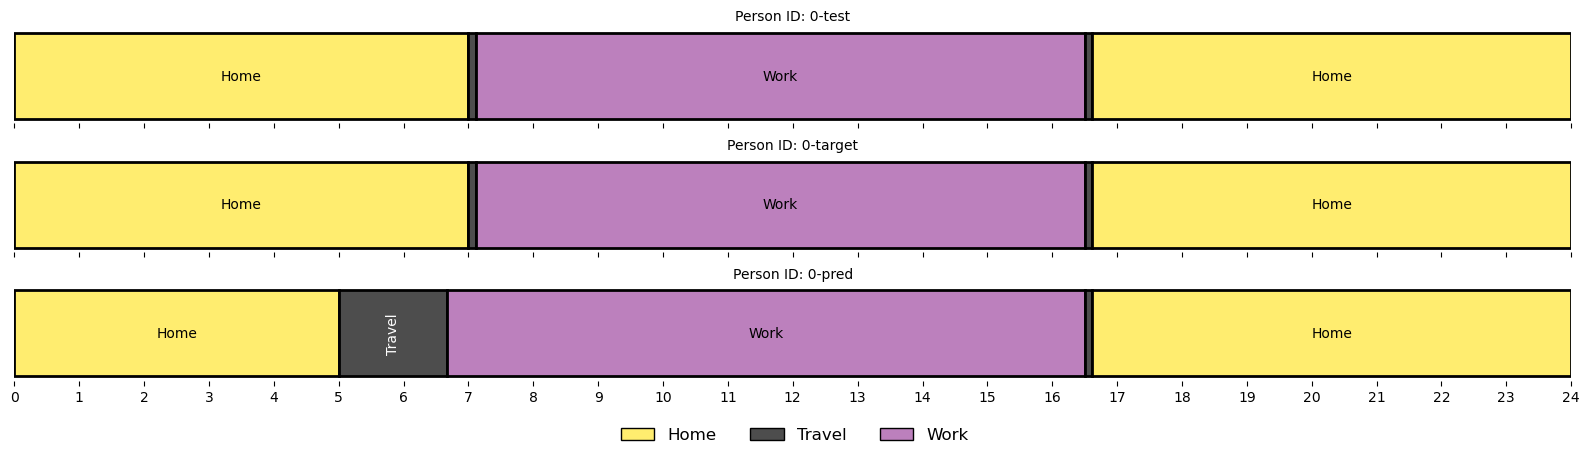

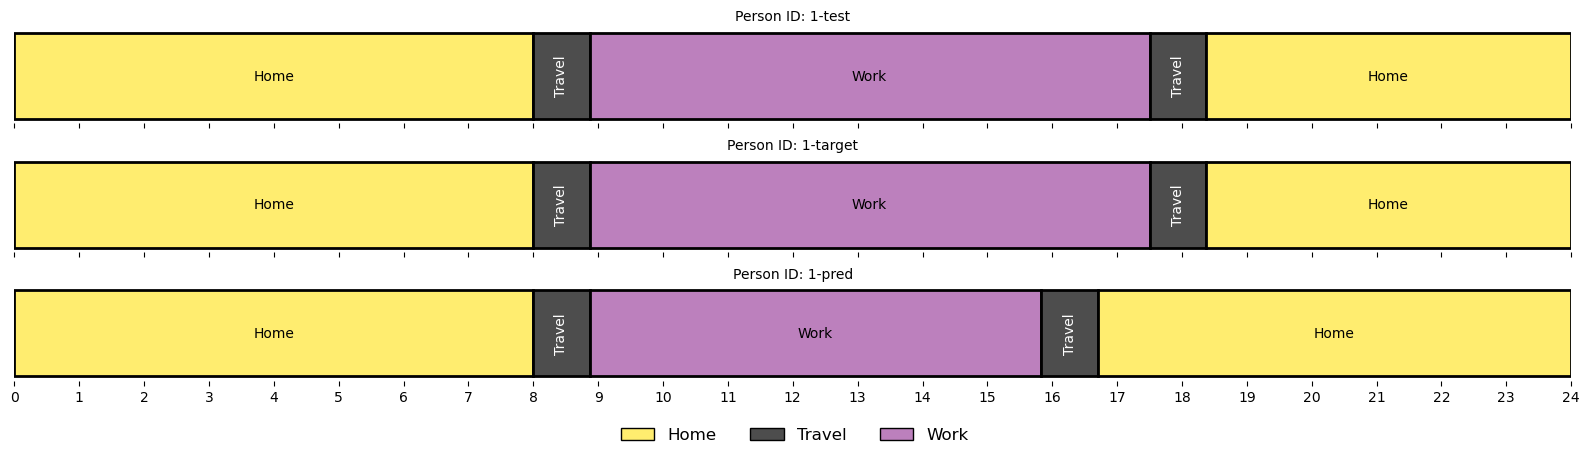

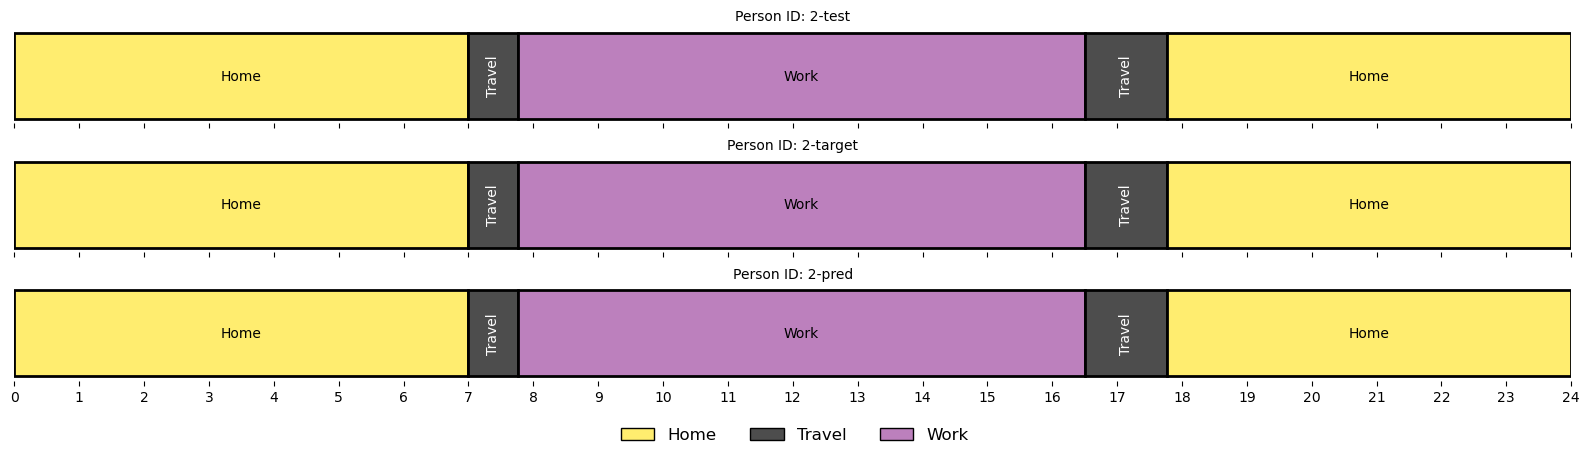

In [27]:
def plot(idx, test, target, pred):
    plans = [build_plan(df[df.pid == idx]) for df in [test, target, pred]]
    persons = [Person(f"{idx}-{i}") for i in ["test", "target", "pred"]]
    for person, plan in zip(persons, plans):
        person.plan = plan
    plot_persons(persons)


for i in range(3):
    plot(i, test, target, pred)